##Importing the needed libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import layers

In [0]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import metrics
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = pd.read_csv('HGK20.CMX.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

## Feature scaling (Normalisation)

In [0]:
# normalise the dataset with standardisation
sc = StandardScaler()
data = sc.fit_transform(dataset)

## split into train and test sets

In [0]:
# split into train and test sets
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

In [0]:
# reshape into X=t and Y=t+1
look_back = 6
X_train, y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [0]:
print("trainX shape: ",X_train.shape)
print("trainY shape: ",y_train.shape)
print("testX shape: ",X_test.shape)
print("testY shape: ",Y_test.shape)

trainX shape:  (806, 6)
trainY shape:  (806,)
testX shape:  (342, 6)
testY shape:  (342,)


##Reshape input to be [samples, time-steps, features]

In [0]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [0]:
print("trainX shape: ",X_train.shape)
print("trainY shape: ",y_train.shape)
print("testX shape: ",X_test.shape)
print("testY shape: ",Y_test.shape)

trainX shape:  (806, 6, 1)
trainY shape:  (806,)
testX shape:  (342, 6, 1)
testY shape:  (342,)


##Causal-retro-causal model

In [0]:
#Creating the model
from keras.layers import Bidirectional
model_bi = tf.keras.Sequential()
model_bi.add(layers.Bidirectional(layers.LSTM(64, input_shape=(6,1)))),
model_bi.add(layers.Dense(1))

In [0]:
model_bi.compile(loss = 'mean_squared_error', optimizer='adam')

In [0]:
#training slightly with the model
history = model_bi.fit(X_train, y_train, epochs=300, batch_size=1, verbose = 1, validation_data=(X_test, Y_test), shuffle=False)
model_bi.reset_states()

Epoch 1/300
806/806 [==============================] - 4s 5ms/step - loss: 0.0310 - val_loss: 0.0445
Epoch 2/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0325 - val_loss: 0.0223
Epoch 3/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0330 - val_loss: 0.0196
Epoch 4/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0336 - val_loss: 0.0183
Epoch 5/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0298 - val_loss: 0.0167
Epoch 6/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0251 - val_loss: 0.0149
Epoch 7/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0227 - val_loss: 0.0133
Epoch 8/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0199 - val_loss: 0.0114
Epoch 9/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0177 - val_loss: 0.0106
Epoch 10/300
806/806 [==============================] - 3s 4ms/step - loss: 0.0163 - val_lo

In [0]:
#checking the summary of the model
model_bi.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  33792     
_________________________________________________________________
dense (Dense)                multiple                  129       
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


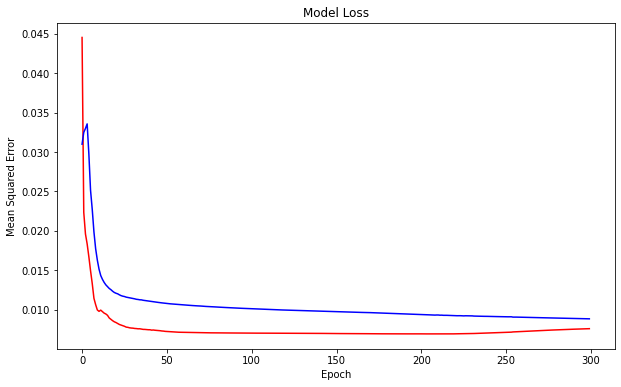

In [0]:
#plot for the model losses and validation losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], color='red', label='validation loss')
plt.plot(history.history['loss'], color='blue', label='train loss')
plt.title('Model Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

##Prediction on test set and prepare for ploting

In [0]:
batch_size=1
train_Score = model_bi.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
model_bi.reset_states()
train_Score = math.sqrt(train_Score)
train_Score = sc.inverse_transform(np.array([[train_Score]]))

test_Score = model_bi.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
model_bi.reset_states()
test_Score = math.sqrt(test_Score)
test_Score = sc.inverse_transform(np.array([[test_Score]]))

In [0]:
print('This is the train_Score:',train_Score)
print('This is the test_Score:', test_Score)

This is the train_Score: [[2.71936169]]
This is the test_Score: [[2.70775286]]


In [0]:
# generate predictions for training and testing
train_Predict_bi = model_bi.predict(X_train, batch_size=1)
test_Predict_bi = model_bi.predict(X_test, batch_size=1)

In [0]:
#measuring the model performnace
mse = mean_squared_error(Y_test, test_Predict_bi)
RMSE = np.sqrt(mse)
mae = mean_absolute_error(Y_test, test_Predict_bi)

print('The Mean Squared Error is: ', mse)
print
print('The Root Mean Squared Error is :', RMSE)
print
print('The Mean Absolute Error is ', mae)

The Mean Squared Error is:  0.0075774305
The Root Mean Squared Error is : 0.08704843
The Mean Absolute Error is  0.06791581


In [0]:
# Shifting train predictions for plotting
train_Plot_bi = np.empty_like(data)
train_Plot_bi[:, :] = np.nan
train_Plot_bi[look_back:len(train_Predict_bi)+look_back, :] = train_Predict_bi

# Shifting test predictions for plotting
test_Plot_bi = np.empty_like(data)
test_Plot_bi[:, :] = np.nan
test_Plot_bi[len(train_Predict_bi)+(look_back*2)+1:len(data)-1, :] = test_Predict_bi

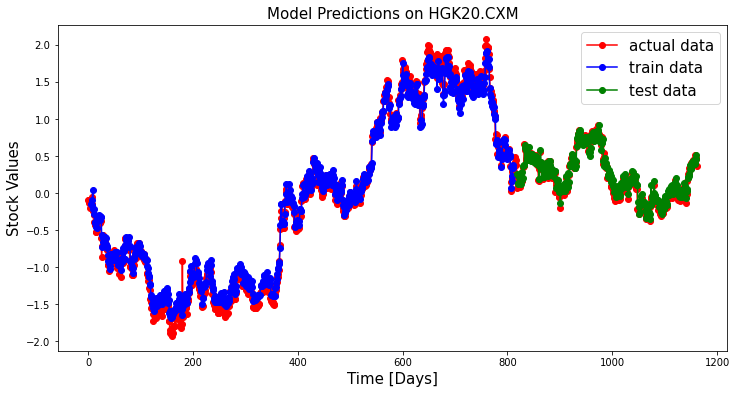

In [0]:
#model predictions using the train-prediction, test-predictions, and target values
plt.figure(figsize=(12, 6))
plt.plot(data, color='red', label='actual data')
plt.plot(train_Plot_bi, color='blue', linestyle="-", label='train data')
plt.plot(test_Plot_bi, color='green', linestyle="-", label='test data')
plt.xlabel('Time [Days]', fontsize=15)
plt.ylabel('Stock Values', fontsize=15)
plt.title('Model Predictions on HGK20.CXM', fontsize=15)
plt.legend(fontsize=15)
plt.show()

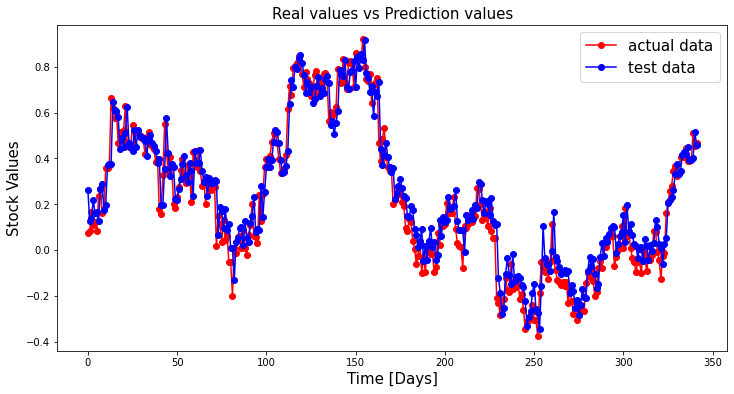

In [0]:
#predictive p[rices vs real prices]
plt.figure(figsize=(12, 6))
plt.plot(Y_test, marker='o', color='red', label='actual data')
plt.plot(test_Predict_bi, marker='o', color='blue', label='test data')
plt.xlabel('Time [Days]', fontsize=15)
plt.ylabel('Stock Values', fontsize=15)
plt.title('Real values vs Prediction values', fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [0]:
#transforming numpy values to real values
Prediction_price = sc.inverse_transform(train_Predict_bi)
Prediction_prices = sc.inverse_transform(test_Predict_bi)
Y_test2 = sc.inverse_transform(Y_test)

In [0]:
print(Prediction_prices, Y_test2)

[[2.7696104]
 [2.7221603]
 [2.7266045]
 [2.754574 ]
 [2.734506 ]
 [2.7356052]
 [2.7211695]
 [2.7714992]
 [2.7793381]
 [2.7394488]
 [2.7470825]
 [2.8082898]
 [2.8104036]
 [2.8105242]
 [2.905566 ]
 [2.893588 ]
 [2.8914032]
 [2.8823361]
 [2.8332846]
 [2.850475 ]
 [2.8358085]
 [2.8583183]
 [2.8986394]
 [2.8424823]
 [2.8352454]
 [2.8295627]
 [2.8630245]
 [2.8359149]
 [2.8624034]
 [2.8530002]
 [2.8513799]
 [2.850961 ]
 [2.845313 ]
 [2.8229039]
 [2.8492613]
 [2.8554091]
 [2.8419707]
 [2.8380125]
 [2.829975 ]
 [2.8119912]
 [2.8178246]
 [2.7460723]
 [2.7464619]
 [2.8019576]
 [2.88096  ]
 [2.826728 ]
 [2.792157 ]
 [2.8096554]
 [2.8049266]
 [2.7561336]
 [2.7545288]
 [2.7719755]
 [2.7874303]
 [2.809998 ]
 [2.8225381]
 [2.7937303]
 [2.7826645]
 [2.8110774]
 [2.7991648]
 [2.7608025]
 [2.8307962]
 [2.8114693]
 [2.8116992]
 [2.8316123]
 [2.7991626]
 [2.782296 ]
 [2.7895815]
 [2.7600296]
 [2.7884562]
 [2.7799275]
 [2.7810206]
 [2.7847965]
 [2.7829225]
 [2.7002661]
 [2.7436888]
 [2.736465 ]
 [2.7115505]

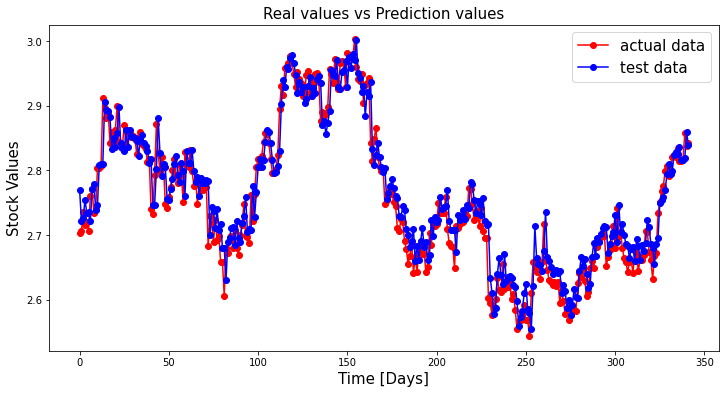

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test2, marker='o', color='red', label='actual data')
plt.plot(Prediction_prices, marker='o', color='blue', label='test data')
plt.xlabel('Time [Days]', fontsize=15)
plt.ylabel('Stock Values', fontsize=15)
plt.title('Real values vs Prediction values', fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [0]:
train1_Plot_bi = np.empty_like(dataset)
train1_Plot_bi[:, :] = np.nan
train1_Plot_bi[look_back:len(Prediction_price)+look_back, :] = Prediction_price

test1_Plot_bi = np.empty_like(dataset)
test1_Plot_bi[:, :] = np.nan
test1_Plot_bi[len(Prediction_price)+(look_back*2)+1:len(data)-1, :] = Prediction_prices

## Preparing the model for future predictions

In [0]:
def predict(num_prediction, model):
    prediction_list = data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    return prediction_list

In [0]:
# num_prediction gives the number of days to predict
num_prediction = 18
forecast = predict(num_prediction, model_bi)
# converting the the prices in real values
forecast = sc.inverse_transform(forecast)

In [0]:
print('', forecast)

 [2.8075    2.8054326 2.805882  2.8068764 2.8111365 2.8163402 2.8207383
 2.8246543 2.827911  2.8304825 2.8325865 2.8343031 2.8356652 2.8367333
 2.8375494 2.838147  2.838564  2.8388352 2.8389919]


In [0]:
#printing the target date predictions 
print('This is the Copper prices for num_prediction in the future', forecast[-1])
print('This is the actual Copper prices', dataset)

This is the Copper prices for num_prediction in the future 2.8389919
This is the actual Copper prices [[2.642 ]
 [2.6295]
 [2.646 ]
 ...
 [2.838 ]
 [2.843 ]
 [2.8075]]


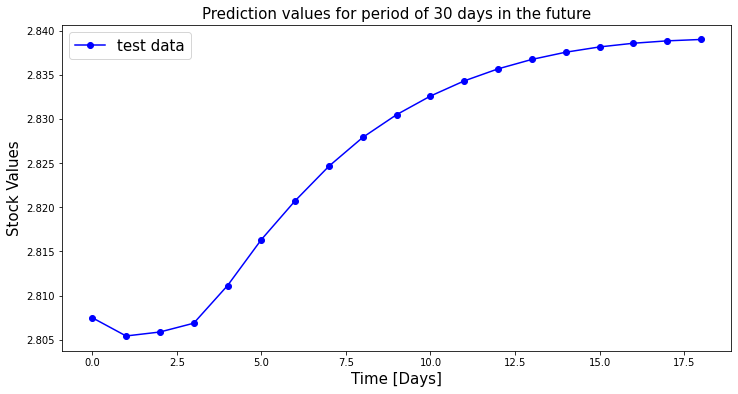

In [0]:
#Plotting the future values
plt.figure(figsize=(12, 6))
plt.plot(forecast, marker='o', color='blue', label='test data')
plt.xlabel('Time [Days]', fontsize=15)
plt.ylabel('Stock Values', fontsize=15)
plt.title('Prediction values for period of 30 days in the future', fontsize=15)
plt.legend(fontsize=15)
plt.show()